<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/Sleep_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
pip install open-ephys-python-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.7-py3-none-any.whl size=39990 sha256=43c93fef5d32b898142e58320e6a206b9b85dce418f4e1755b0eb425fc9e7d78
  Stored in directory: /root/.cache/pip/wheels/99/0a/29/c0d2d399ff078b2a96c61e36a0a219a8fbb545a7acd261ce80
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1265 sha256=306f4ddf883472e5fea0f4b60128e08cb4ff4d0b7f9d57269af1b8758fe2bddb
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
! pip install pactools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.9 MB/s eta 0:00:00


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd


from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

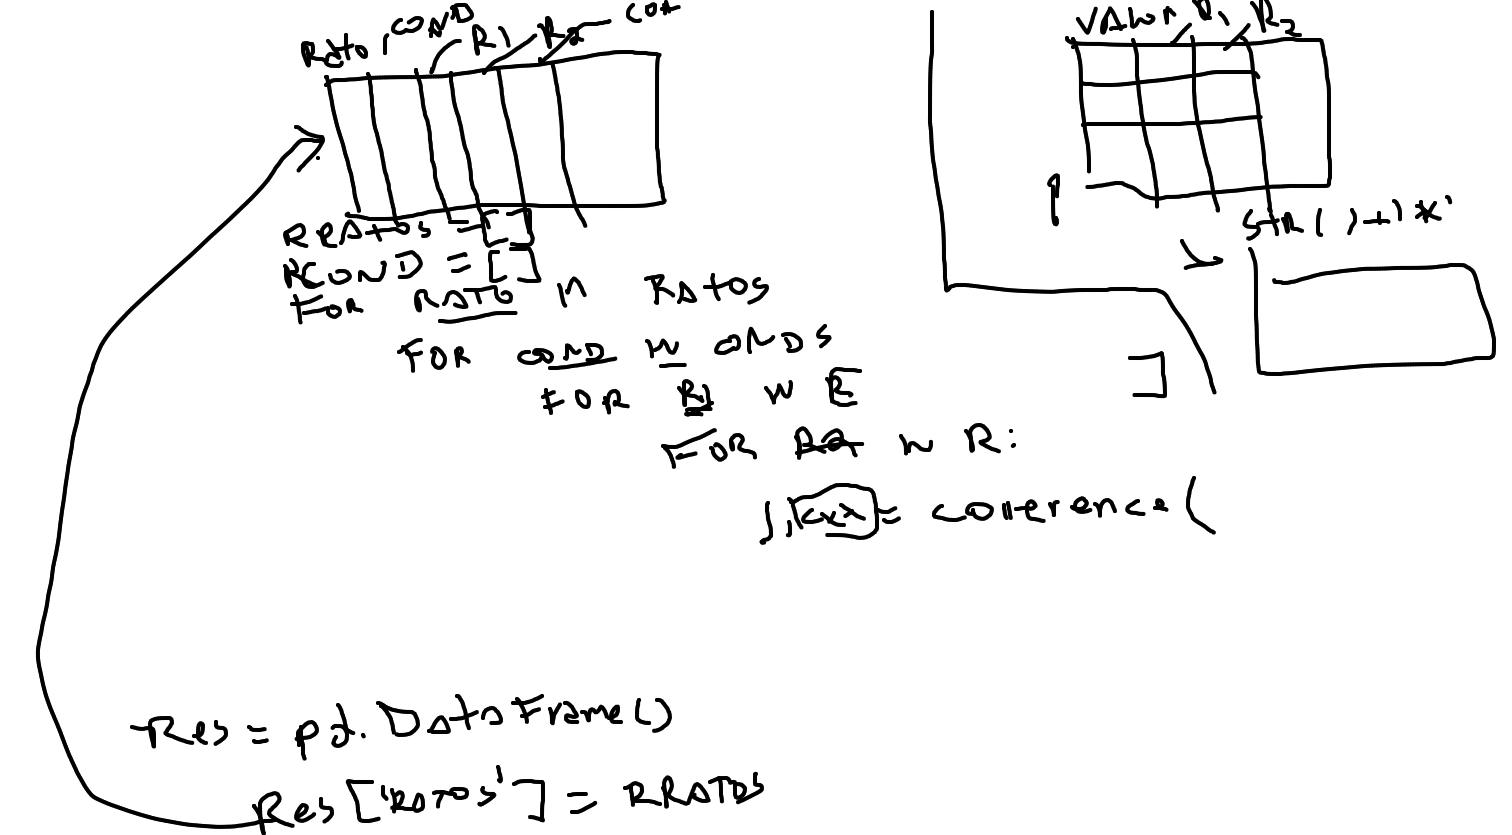

> # FUNÇÕES



In [ ]:
def prewiew(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 45
  fc_high = 65
  order = 100
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def prewiew_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
def load_events(path):


  load = Session(path).recordnodes[0].recordings[0]
  event = load.events
  CS = event[(event['line'] ==2)&(event['state']==1)]

  return(pd.DataFrame({'CS': CS}))


In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_cg,ch_il):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl)-1)]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_cg)-1)]
  data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_il)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL}))

In [ ]:
# # CARREGAR O DADO

# def load_data(path,inicio,final,ch_prl,ch_cg,ch_il):
#   load = Session(path).recordnodes[0].recordings[0]
#   t_raw= load.continuous[0].timestamps
#   t = t_raw-t_raw[0]

#   # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
#   data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_prl]
#   data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_cg]
#   data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,ch_il]


#   # Parâmetros do filtro notch
#   fs = 1000
#   f0 = 60.0  # Frequência a ser filtrada (60 Hz)
#   Q = 30.0   # Fator de qualidade (ajuste conforme necessário)

#   # Projete o filtro notch
#   b, a = signal.iirnotch(f0, Q, fs)


#   PRL = signal.lfilter(b, a, data_prl)
#   CG = signal.lfilter(b, a, data_cg)
#   IL = signal.lfilter(b, a, data_il)

#   return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL, 'status': 'animal_parado'}))

In [ ]:
def media_coherence(df, condicao, r1, r2):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao})
    return (result_df)

In [ ]:

# ESSA FUNÇÃO APLICA UM FILTRO PARA THETA

# def get_psd( data_psd  ):
#   filtered_theta = filtfilt(b, a, data_psd)
#   f, p = welch(filtered_theta, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
#   df_psd = pd.DataFrame({'PSD': p, 'F': f})

#   return(df_psd )

In [ ]:

# FILTRO THETA PARA FUNÇÃO ACIMA


# from scipy.signal import butter, filtfilt

# # Dados de exemplo
# fs = 1000  # Frequência de amostragem


# # Filtrar theta (4 a 10 Hz)
# lowcut = 4
# highcut = 10
# nyq = 0.5 * fs
# low = lowcut / nyq
# high = highcut / nyq

# # Projeta o filtro usando a função butter
# order = 4  # Ordem do filtro
# b, a = butter(order, [low, high], btype='band')

# Aplica o filtro à sinal
# filtered_theta = filtfilt(b, a, signal)

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
# FILTRO SIMPLES


def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# Causalidade de granger

def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh):

  envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
  test_data_1 = np.squeeze(envelope_data_1)

  envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
  test_data_2 = np.squeeze(envelope_data_2)

  matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
  lag = [int(math.sqrt(len(matrix_test)))]
  gc = grangercausalitytests(matrix_test,lag,verbose = False)
  results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

  p_label = []
  p = results_test_r[0]
  if p <= 0.01:
    p_label.append('p<0.01')
  elif 0.01 < p < 0.05:
    p_label.append('p<0.05')
  elif p == 0.05:
    p_label.append('p=0.05')
  else:
    p_label.append('p>0.05')

  df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': p_label, 'r1': r1, 'r2': r2, 'condicao': condicao}, index=['Results'])

  return(df_granger )

> # ANÁLISE DOS DADOS

REMs = low delta,
      high theta/delta

NREMs = high delta, low theta/delta

active = low delta,
         low theta/delta

# Estimation of REM Sleep, Slow Wave Sleep, Active Waking Periods, and Quiet Waking

All periods were defined by spectral analysis combined with visual inspection of the video recordings. REM epochs were defined as periods of quiescence, REM sleep posture, and elevated theta power (theta/delta > 4), while SWS epochs were defined as periods of quiescence, SWS posture and low theta power (theta/delta < 4). Active waking periods were obtained by visual inspection of locomotion behavior and dominating theta oscillations, while quiet waking epochs were obtained as absence of exploratory behavior, clear signs of waking, and absence of theta oscillations. [texto do link](https://www.frontiersin.org/articles/10.3389/fncir.2017.00029/full)

NormAmp = (Amp - min(Amp)) / (max(Amp) - min(Amp)))  [texto do link](https://www.frontiersin.org/articles/10.3389/fncir.2017.00029/full)

In [ ]:
ratos = { 'CCM04': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 25 },

                    'inicio': { 'OF_pre': 10000,
                               'OF_pos': 490000   } ,

                    'sono': { 'bloco_1': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_1',
                              'bloco_2':  '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_2',
                              'bloco_3': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_3',
                              'bloco_4': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_4',
                              'bloco_5': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_5',
                               'bloco_6': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM68_CCM04/CCM68_04_HOMECAGE_6'},

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_SCREENING'     },

          'CCM05': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCM05_OF_POS_SCREEN_2' },

                    'canais': { 'prl':22 ,
                                'cg':29 ,
                                'il':27  },

                    'inicio': { 'OF_pre': 590000 ,
                                'OF_pos':  242000  } ,

                    'sono': { 'bloco_1': '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_1',
                            'bloco_2':   '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_2',
                            'bloco_3':  '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_3',
                            'bloco_4':  '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_4',
                            'bloco_5':   '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_5',
                            'bloco_6':   '/content/drive/Shareddrives/Stress Sleep/EPHYS/EXP SLEEP/CCM05/CCM05_HOMECAGE_6' },


                     'screening':  '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_SCREENING' }}

In [ ]:
# CRIANDO DF COM OS DADOS

dataframes = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
      path = ratos[str(rato)]['condicao'][str(condicao)]
      inicio = ratos[str(rato)]['inicio'][str(condicao)]
      final = inicio + 90000

      ch_prl =  ratos[rato]['canais']['prl']
      ch_cg =  ratos[rato]['canais']['cg']
      ch_il =  ratos[rato]['canais']['il']

      df_temp = load_data(path,inicio,final, ch_prl, ch_cg, ch_il)
      df_temp['animal'] = str(rato)
      df_temp['condicao'] = str(condicao)

      dataframes.append(df_temp)

df = pd.concat(dataframes)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording2/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO 

# FIG 1: PSD 0-100HZ pre-pos

In [ ]:
dataframe_welch_prl = []
dataframe_welch_acc = []
dataframe_welch_il = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
      df_temp_prl = get_psd(df[(df['animal'] == str(rato)) & (df['condicao'] == condicao )]['data_PRL'] )
      df_temp_prl[ 'animal'] = str(rato)
      df_temp_prl['condicao'] = str(condicao)
      df_temp_prl['regiao'] = str('PRL')

      dataframe_welch_prl.append(df_temp_prl)

      df_temp_acc = get_psd(df[(df['animal'] == str(rato)) & (df['condicao'] == condicao )]['data_CG'] )
      df_temp_acc[ 'animal'] = str(rato)
      df_temp_acc['condicao'] = str(condicao)
      df_temp_acc['regiao'] = str('ACC')

      dataframe_welch_acc.append(df_temp_acc)

      df_temp_il = get_psd(df[(df['animal'] == str(rato)) & (df['condicao'] == condicao )]['data_IL'] )
      df_temp_il[ 'animal'] = str(rato)
      df_temp_il['condicao'] = str(condicao)
      df_temp_il['regiao'] = str('IL')

      dataframe_welch_il.append(df_temp_il)

df_psd_prl = pd.concat(dataframe_welch_prl)
df_psd_acc = pd.concat(dataframe_welch_acc)
df_psd_il = pd.concat(dataframe_welch_il)
df_psd = pd.concat([df_psd_prl, df_psd_acc, df_psd_il])
df_psd['banda'] = df_psd['F'].apply(mapear_banda)

grouped_df = df_psd.groupby(['condicao', 'regiao', 'F'])

# Calculando a média para cada grupo
mean_psd = grouped_df['PSD'].mean().reset_index()
mean_psd['banda'] = mean_psd['F'].apply(mapear_banda)

In [ ]:
mean_prl_pre =   pd.DataFrame({'PSD' : 10 * np.log10(np.array(mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)), 'condicao': 'PRE', 'REGIAO': 'PRL'})
mean_cg_pre = pd.DataFrame( {'PSD' : 10 * np.log10( np.array(mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['PSD'] + 1e-10)), 'condicao': 'PRE', 'REGIAO': 'ACC'})
mean_il_pre = pd.DataFrame( {'PSD' :  10 * np.log10(np.array(mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)), 'condicao': 'PRE', 'REGIAO': 'IL'})

mean_prl_pos = pd.DataFrame(  {'PSD' :  10 * np.log10( np.array( mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)),  'condicao': 'POS', 'REGIAO': 'PRL'})
mean_cg_pos = pd.DataFrame( {'PSD' :  10 * np.log10(np.array(mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['PSD'] + 1e-10)),  'condicao': 'POS', 'REGIAO': 'ACC'})
mean_il_pos = pd.DataFrame( {'PSD' :  10 * np.log10(np.array( mean_psd[(mean_psd['banda'] == 'Theta') & (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)),  'condicao': 'POS', 'REGIAO': 'IL'})

df_barplot_theta = pd.concat([mean_prl_pre, mean_cg_pre, mean_il_pre, mean_prl_pos, mean_cg_pos, mean_il_pos ])

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


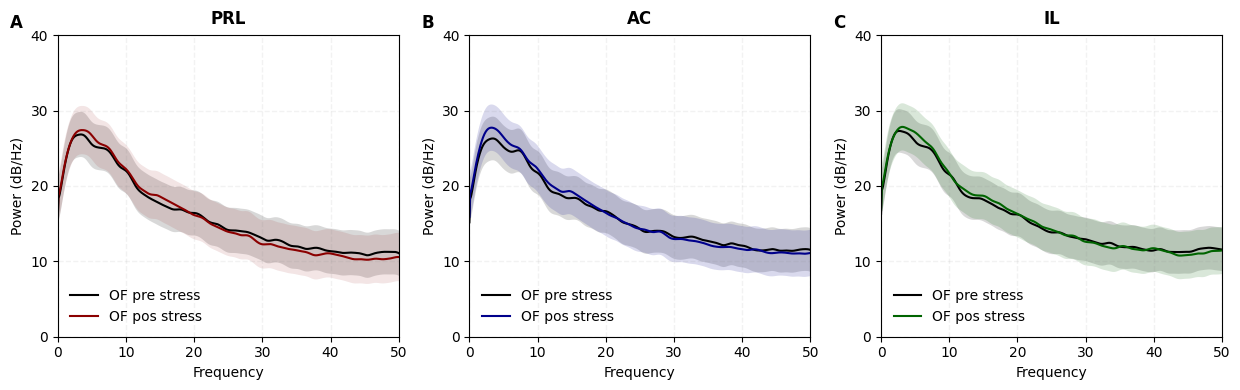

In [ ]:

figura = plt.figure(figsize=(12.5,4))
# figura.suptitle('PSD OF pre and pos stress session', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
ax1 = figura.add_subplot(131)

ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['F']
y_prl = 10 * np.log10 (mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std = np.std(y_prl)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['F']
y_pos_prl =  10 * np.log10 ( mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)
std_pos = np.std(y_pos_prl)/np.sqrt(6)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.xlim(0,50)
plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
plt.yticks(np.arange(0, 41, 10))

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(132)
ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['F']
y_cg = 10 * np.log10( mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['PSD']   + 1e-10)
std_cg = np.std(y_cg)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC') ]['F']
y_pos_cg = 10 * np.log10( mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['PSD']  + 1e-10)
std_pos_cg = np.std(y_pos_cg)/np.sqrt(6)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,50)
plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
plt.yticks(np.arange(0, 41, 10))

ax3 = figura.add_subplot(133)
ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['F']
y_il = 10 * np.log10(mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_il = np.std(y_il)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['F']
y_pos_il = 10 * np.log10(mean_psd[(mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_pos_il = np.std(y_pos_il)/np.sqrt(6)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,50)
plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
plt.yticks(np.arange(0, 41, 10))

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/psd_depois_de_corrigir.jpeg')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


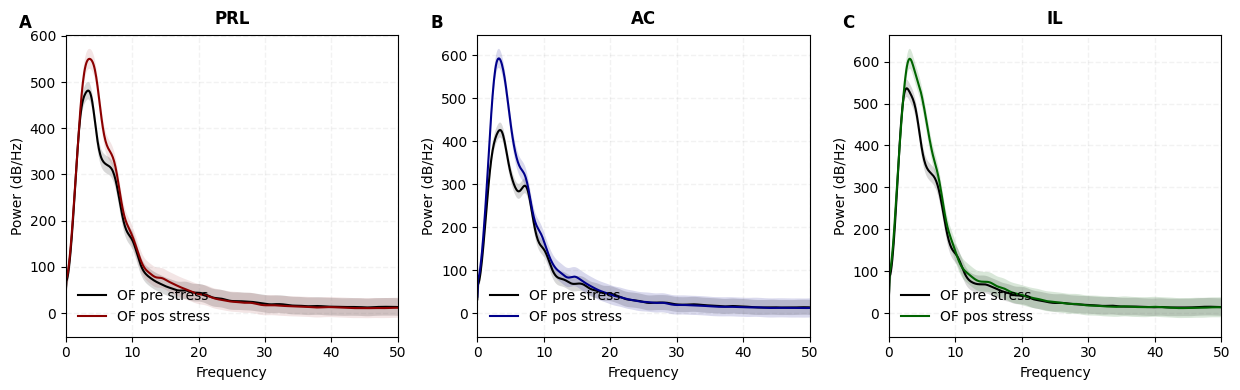

In [ ]:

figura = plt.figure(figsize=(12.5,4))
# figura.suptitle('PSD OF pre and pos stress session', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
ax1 = figura.add_subplot(131)

ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['F']
y_prl =  (mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std = np.std(y_prl)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['F']
y_pos_prl =   ( mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)
std_pos = np.std(y_pos_prl)/np.sqrt(6)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.xlim(0,50)
# plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
# plt.yticks(np.arange(0, 41, 10))

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(132)
ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['F']
y_cg =( mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['PSD']   + 1e-10)
std_cg = np.std(y_cg)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC') ]['F']
y_pos_cg = ( mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['PSD']  + 1e-10)
std_pos_cg = np.std(y_pos_cg)/np.sqrt(6)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,50)
# plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
# plt.yticks(np.arange(0, 41, 10))

ax3 = figura.add_subplot(133)
ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['F']
y_il =(mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_il = np.std(y_il)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['F']
y_pos_il = (mean_psd[(mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_pos_il = np.std(y_pos_il)/np.sqrt(6)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,50)
# plt.ylim(0,40)
plt.xticks(np.arange(0, 51, 10))
# plt.yticks(np.arange(0, 41, 10))

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/psd_depois_de_corrigir.jpeg')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


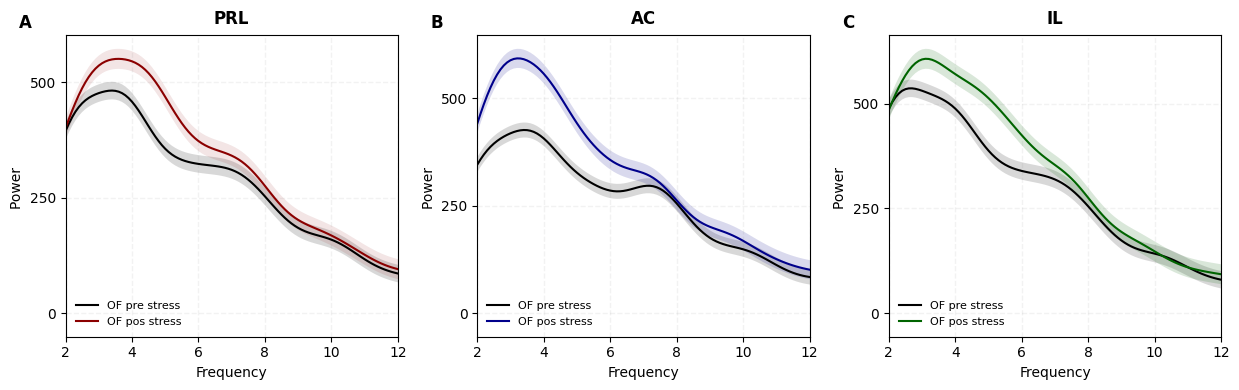

In [ ]:

figura = plt.figure(figsize=(12.5,4))
# figura.suptitle('PSD OF pre and pos stress session', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
ax1 = figura.add_subplot(131)

ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['F']
y_prl = (mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std = np.std(y_prl)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['F']
y_pos_prl =   ( mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)
std_pos = np.std(y_pos_prl)/np.sqrt(6)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power ')
plt.xlim(2,12)
# plt.ylim(10,40)
plt.xticks(np.arange(2, 13, 2))
plt.yticks(np.arange(0, 501,250))

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(132)
ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['F']
y_cg = ( mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['PSD']   + 1e-10)
std_cg = np.std(y_cg)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC') ]['F']
y_pos_cg =( mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['PSD']  + 1e-10)
std_pos_cg = np.std(y_pos_cg)/np.sqrt(6)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power ')
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)

plt.xlim(2,12)
# plt.ylim(10,40)
plt.xticks(np.arange(2, 13, 2))
plt.yticks(np.arange(0, 501,250))

ax3 = figura.add_subplot(133)
ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['F']
y_il =(mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_il = np.std(y_il)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['F']
y_pos_il =(mean_psd[(mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_pos_il = np.std(y_pos_il)/np.sqrt(6)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=8, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power ')
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(2,12)
# plt.ylim(10,40)
plt.xticks(np.arange(2, 13, 2))
plt.yticks(np.arange(0, 501,250))

plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/FIGURES/psd_filtered_theta.jpeg')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


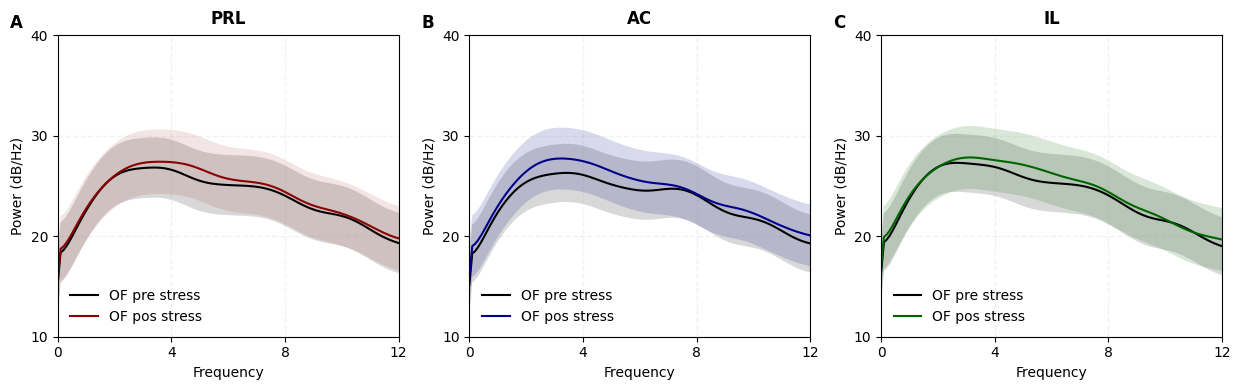

In [ ]:
# THETA PSD


figura = plt.figure(figsize=(12.5,4))
# figura.suptitle('PSD OF pre and pos stress session', fontweight ="bold", fontsize = 12)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
ax1 = figura.add_subplot(131)

ax1.text(-0.14, 1.07, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['F']
y_prl = 10 * np.log10 (mean_psd[(mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std = np.std(y_prl)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['F']
y_pos_prl =  10 * np.log10 ( mean_psd[ (mean_psd['condicao'] == 'OF_pos')  & (mean_psd['regiao'] == 'PRL')]['PSD'] + 1e-10)
std_pos = np.std(y_pos_prl)/np.sqrt(6)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.xlim(0,12)
plt.ylim(10,40)

plt.xticks(np.arange(0, 13, 4))
plt.yticks(np.arange(10, 41, 10))

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(132)
ax2.text(-0.14, 1.07, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = mean_psd[ (mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['F']
y_cg = 10 * np.log10( mean_psd[(mean_psd['condicao'] == 'OF_pre')  & (mean_psd['regiao'] == 'ACC')]['PSD']   + 1e-10)
std_cg = np.std(y_cg)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[(mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['F']
y_pos_cg = 10 * np.log10( mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'ACC')]['PSD']  + 1e-10)
std_pos_cg = np.std(y_pos_cg)/np.sqrt(6)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,12)
plt.ylim(10,40)

plt.xticks(np.arange(0, 13, 4))
plt.yticks(np.arange(10, 41, 10))

ax3 = figura.add_subplot(133)
ax3.text(-0.14, 1.07, "C", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['F']
y_il = 10 * np.log10(mean_psd[ (mean_psd['condicao'] == 'OF_pre') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_il = np.std(y_il)/np.sqrt(6)  # Cálculo do desvio padrão

x_pos = mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['F']
y_pos_il = 10 * np.log10(mean_psd[ (mean_psd['condicao'] == 'OF_pos') & (mean_psd['regiao'] == 'IL')]['PSD'] + 1e-10)
std_pos_il = np.std(y_pos_il)/np.sqrt(6)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=10, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)
plt.xlim(0,12)
plt.ylim(10,40)

plt.xticks(np.arange(0, 13, 4))
plt.yticks(np.arange(10, 41, 10))

plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/FIGURES/psd_filtered_theta_log10.jpeg')

plt.show()





In [ ]:
df_psd

,PSD,F,animal,condicao,regiao,banda
0,2.163658e+00,0.0,CCM497,OF_pre,PRL,Delta
1,4.259976e+00,0.1,CCM497,OF_pre,PRL,Delta
2,4.063629e+00,0.2,CCM497,OF_pre,PRL,Delta
3,3.754604e+00,0.3,CCM497,OF_pre,PRL,Delta
4,3.357925e+00,0.4,CCM497,OF_pre,PRL,Delta
...,...,...,...,...,...,...
4996,5.307382e-17,499.6,CCM193,OF_pos,IL,High gamma
4997,5.216374e-17,499.7,CCM193,OF_pos,IL,High gamma
4998,5.114111e-17,499.8,CCM193,OF_pos,IL,High gamma
4999,5.034669e-17,499.9,CCM193,OF_pos,IL,High gamma


In [ ]:
# FAZENDO O DF COM A MEDIA DO PSD DE CADA ANIMAL

agrupar = df_psd.groupby(['animal', 'condicao', 'regiao', 'banda'])

#  média para cada grupo
mean_psd_animal = agrupar['PSD'].mean().reset_index()

psd_theta_por_animal = pd.DataFrame(mean_psd_animal[(mean_psd_animal['banda'] == 'Theta') ])

psd_theta_por_animal['PSD'] = np.log10(psd_theta_por_animal['PSD'] + 1e-10)



In [ ]:
psd_theta_por_animal

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

,animal,condicao,regiao,banda,PSD
5,CCM04,OF_pos,ACC,Theta,2.355783
11,CCM04,OF_pos,IL,Theta,2.448845
17,CCM04,OF_pos,PRL,Theta,2.476464
23,CCM04,OF_pre,ACC,Theta,2.411706
29,CCM04,OF_pre,IL,Theta,2.534582
35,CCM04,OF_pre,PRL,Theta,2.579607
41,CCM05,OF_pos,ACC,Theta,2.539636
47,CCM05,OF_pos,IL,Theta,2.545894
53,CCM05,OF_pos,PRL,Theta,2.632017
59,CCM05,OF_pre,ACC,Theta,2.225358


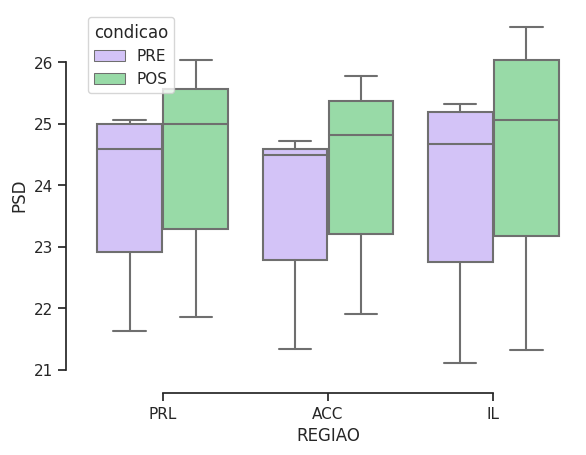

In [ ]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="REGIAO", y="PSD",
            hue="condicao", palette=["m", "g"],
            data=df_barplot_theta)

sns.despine(offset=10, trim=True)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


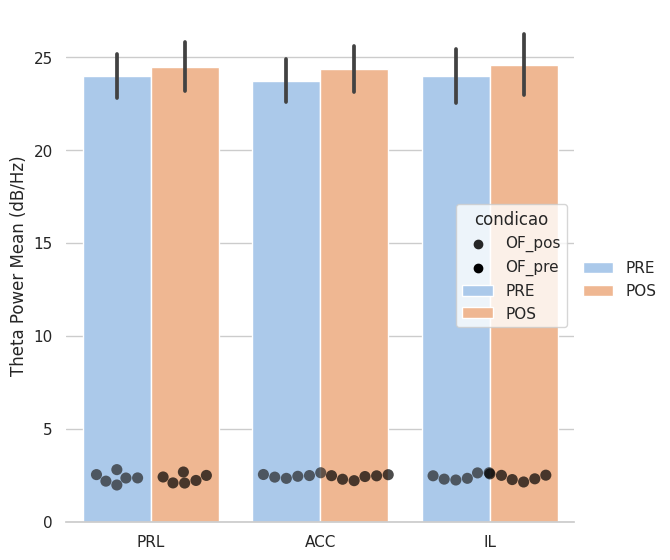

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")


g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="REGIAO", y="PSD", hue="condicao",
    errorbar='sd', palette="pastel", alpha=1, height=6
)

sns.swarmplot(
    data=psd_theta_por_animal, x="regiao", y="PSD", hue="condicao",
    color="black", size=8, dodge=True, alpha=0.7    #, ax=g.ax
)





g.despine(left=True)
g.set_axis_labels("", 'Theta Power Mean (dB/Hz)')
g.legend.set_title("")

> # FIG 2: THETA PSD

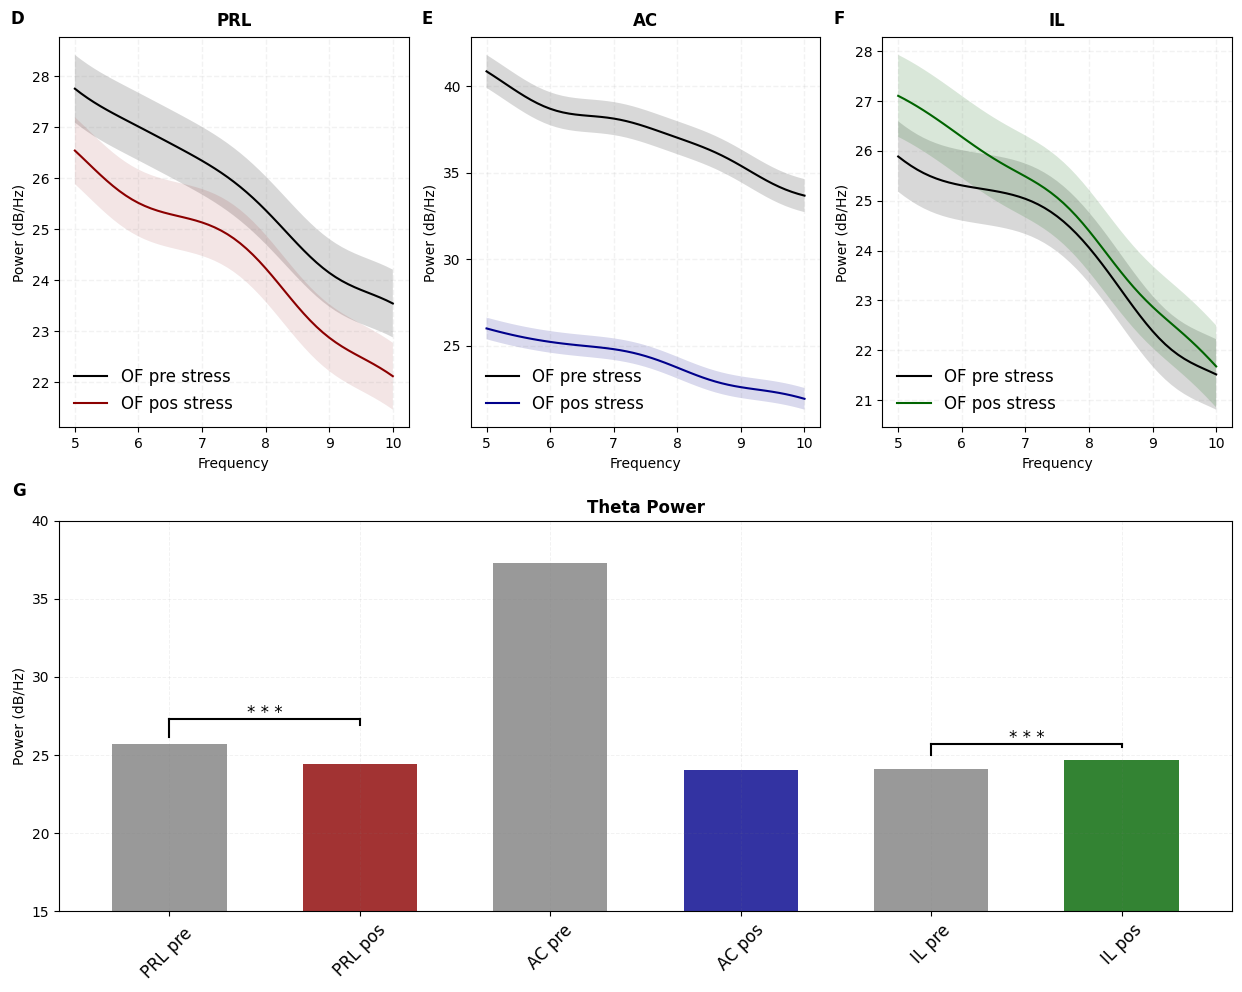

In [ ]:
figura = plt.figure(figsize=(12.5,10))
# figura.suptitle('PSD OF pre and pos screening', fontweight ="bold", fontsize = 12)
gs = gridspec.GridSpec(2, 3)


ax1 = figura.add_subplot(gs[0, 0])
ax1.text(-0.14, 1.07, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")
x = df_welch_pre [(df_welch_pre['banda'] == 'Theta') ]['f']

y_prl = 10 * np.log10(df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['mean_power_prl'] )
std = np.std(y_prl)/np.sqrt(4)

x_pos = df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['f']
y_pos_prl = 10 * np.log10(df_welch_pos[(df_welch_pos['banda'] == 'Theta')]['mean_power_prl'])
std_pos = np.std(y_pos_prl)/np.sqrt(4)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='OF pos stress')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
# plt.xlim(5,10)
# plt.ylim(20,30)

plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

ax2 = figura.add_subplot(gs[0, 1])
ax2.text(-0.14, 1.07, "E", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top")

x = df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['f']
y_cg = 10 * np.log10(df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['mean_power_cg'] )
std_cg = np.std(y_cg)/np.sqrt(4)  # Cálculo do desvio padrão

x_pos = df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['f']
y_pos_cg = 10 * np.log10(df_welch_pos[(df_welch_pos['banda'] == 'Theta')]['mean_power_cg'])
std_pos_cg = np.std(y_pos_cg)/np.sqrt(4)


plt.plot(x, y_cg, linewidth=1.5, color='black', label='OF pre stress')
plt.fill_between(x, y_cg - std_cg, y_cg + std_cg, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_cg, linewidth=1.5, color='darkblue', label='OF pos stress')
plt.fill_between(x_pos, y_pos_cg - std_pos_cg, y_pos_cg + std_pos_cg, color='darkblue', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
# plt.xlim(5,10)
# plt.ylim(20,30)
plt.title('AC', fontweight='bold',  pad = 8, fontsize = 12)

ax3 = figura.add_subplot(gs[0, 2])
ax3.text(-0.14, 1.07, "F", transform=ax3.transAxes, fontsize=12, fontweight="bold", va="top")


x = df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['f']
y_il = 10 * np.log10(df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['mean_power_il'] )
std_il = np.std(y_il)/np.sqrt(4)  # Cálculo do desvio padrão

x_pos = df_welch_pre [(df_welch_pre['banda'] == 'Theta')]['f']
y_pos_il = 10 * np.log10(df_welch_pos[(df_welch_pos['banda'] == 'Theta')]['mean_power_il'])
std_pos_il = np.std(y_pos_il)/np.sqrt(4)


plt.plot(x, y_il, linewidth=1.5, color='k', label='OF pre stress')
plt.fill_between(x, y_il - std_il, y_il + std_il, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_il, linewidth=1.5, color='darkgreen', label='OF pos stress')
plt.fill_between(x_pos, y_pos_il - std_pos_il, y_pos_il + std_pos_il, color='darkgreen', alpha=0.15, edgecolor=None)


plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=12, loc='lower left', frameon=False)
plt.xlabel('Frequency')
plt.ylabel('Power (dB/Hz)')
# plt.xlim(5,10)
# plt.ylim(20,30)
plt.title('IL', fontweight='bold',  pad = 8, fontsize = 12)



ax4 = figura.add_subplot(gs[1, :])

ax4.text(-0.04, 1.1, "G", transform=ax4.transAxes, fontsize=12, fontweight="bold", va="top")

plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')


reg = (np.mean(y_prl),np.mean(y_pos_prl), np.mean(y_cg),np.mean( y_pos_cg),np.mean( y_il), np.mean(y_pos_il))

labels = ['PRL pre ', 'PRL pos','AC pre', 'AC pos', 'IL pre', 'IL pos' ]

plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.1, axis = 'both', which = 'Both')

color=[ 'grey', 'darkred', 'grey' ,'darkblue' ,'grey', 'darkgreen']

# Criar as barras com hachura

for i in range(len(reg)):
    plt.bar(labels[i], reg[i], width=0.6,color=color[i],  align='center', alpha=0.8)

plt.plot([0, 1], [27.3, 27.3], 'k-', linewidth=1.5)
plt.plot([0, 0], [27.3, 26.15], 'k-', linewidth=1.5)
plt.plot([1, 1], [27.3, 26.9], 'k-', linewidth=1.5)
plt.text(0.5, 27.4, '* * *', color='k', fontsize=12, horizontalalignment='center')

# plt.plot([2, 3], [36, 36], 'k-', linewidth=1.5)
# plt.plot([2, 2], [36, 35], 'k-', linewidth=1.5)
# plt.plot([3, 3], [36, 35], 'k-', linewidth=1.5)

# # plt.text(2.5, 36.5, '* * *', color='k', fontsize=12, horizontalalignment='center')

plt.plot([4, 5], [25.7, 25.7], 'k-', linewidth=1.5)
plt.plot([4, 4], [25.7, 25], 'k-', linewidth=1.5)
plt.plot([5, 5], [25.7, 25.5], 'k-', linewidth=1.5)

plt.text(4.5, 25.8, '* * *', color='k', fontsize=12, horizontalalignment='center')

plt.legend(fontsize=12, loc='upper right', frameon=False)
plt.title('Theta Power', fontweight='bold', pad=6, fontsize=12)
plt.ylim(15,40)
plt.ylabel('Power (dB/Hz)')
plt.xticks(fontsize=12, rotation=45)


plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figures/theta_pre_pos_4animais.jpeg')
plt.show()

In [ ]:
stat_cg = sp.stats.ttest_rel(y_prl, y_pos_prl, alternative = 'two-sided')
stat_cg

TtestResult(statistic=77.78126748092026, pvalue=7.818774639130924e-54, df=50)

In [ ]:
stat_cg = sp.stats.ttest_rel(y_cg, y_pos_cg, alternative = 'two-sided')
stat_cg

TtestResult(statistic=130.40294704192587, pvalue=5.3567230684867105e-65, df=50)

In [ ]:
stat_il = sp.stats.ttest_rel( y_il, y_pos_il, alternative = 'two-sided')
stat_il

TtestResult(statistic=-13.079083028246833, pvalue=9.22427320288932e-18, df=50)

> # COHERENCE

In [ ]:
coher_prl_cg = []
coher_prl_il = []
coher_cg_il = []
fazendo_df_coherence = []

for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    f,c_prl_cg = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao))]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao))]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'PRL'
    r2 = 'ACC'
    coher_prl_cg.append(c_prl_cg)
    df_cohe_prl_cg = pd.DataFrame({'coherence': c_prl_cg,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_prl_cg)

    f,c_prl_il = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'PRL'
    r2 = 'IL'
    coher_prl_il.append(c_prl_il)
    df_cohe_prl_il = pd.DataFrame({'coherence': c_prl_il,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_prl_il)

    f,c_cg_il = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'ACC'
    r2 = 'IL'
    coher_cg_il.append(c_cg_il)
    df_cohe_cg_il = pd.DataFrame({'coherence': c_cg_il,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_cg_il)

df_coherence = pd.concat(fazendo_df_coherence)
df_coherence['indice'] = df_coherence.index


In [ ]:
cohe_prl_cg_pre = media_coherence(  df_coherence,'OF_pre', 'PRL', 'ACC' )
cohe_prl_cg_pos = media_coherence(  df_coherence,'OF_pos', 'PRL', 'ACC' )
cohe_prl_il_pre = media_coherence(  df_coherence,'OF_pre', 'PRL', 'IL' )
cohe_prl_il_pos = media_coherence(  df_coherence,'OF_pos', 'PRL', 'IL' )
cohe_cg_il_pre = media_coherence(  df_coherence,'OF_pre', 'ACC', 'IL')
cohe_cg_il_pos = media_coherence(  df_coherence,'OF_pos', 'ACC', 'IL' )

In [ ]:
result_coh = pd.concat([cohe_prl_cg_pre, cohe_prl_cg_pos, cohe_prl_il_pre, cohe_prl_il_pos, cohe_cg_il_pre,  cohe_cg_il_pos], axis=0 )
result_coh['frequencia'] = result_coh.index


# Criando nova coluna 'banda' usando a função apply()
result_coh['banda'] = result_coh['frequencia'].apply(mapear_banda)

coh = result_coh.drop(columns='frequencia')


In [ ]:
coh

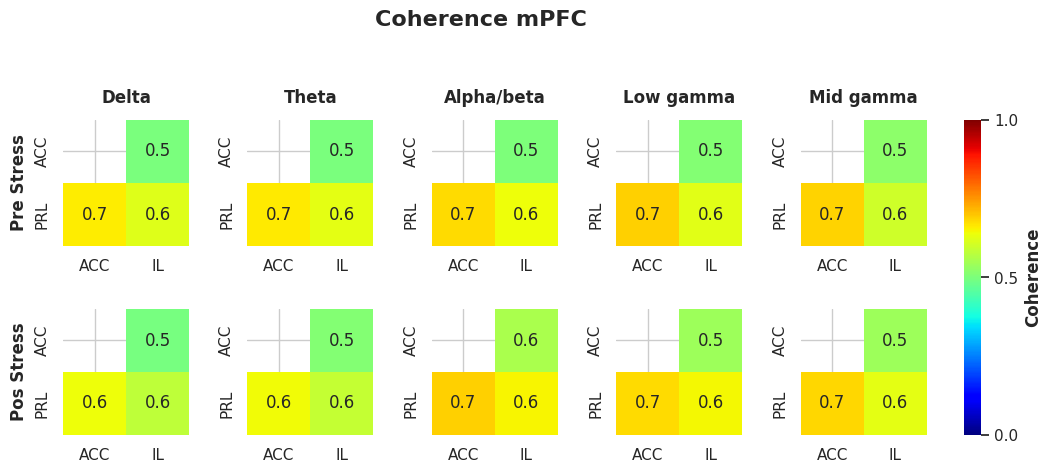

In [ ]:
canais = ['PRL', 'AC', 'IL']

f, axs = plt.subplots( 2,5, figsize=(11.5,5), gridspec_kw={'hspace': 0.5})
plt.suptitle('Coherence mPFC', fontsize=16, fontweight='bold', y=1.1, x=0.5)
bandas_coh = ['Delta', 'Theta', 'Alpha/beta', 'Low gamma',  'Mid gamma']
heatmap_pre = []
heatmap_pos = []
for banda in range(len(bandas_coh)):
    for i in range(len(canais)):
        for j in range(len(canais)):
            pre = coh[ (coh.banda == bandas_coh[banda] )  & (coh.condicao == 'OF_pre') ]

            pos = coh[ (coh.banda == bandas_coh[banda] )  & (coh.condicao == 'OF_pos') ]

    # mask = np.tril(np.ones_like(pre, dtype=bool))
    pivot_pre = pre.pivot_table(index='r1', columns='r2', values='coherence')
    pivot_pos = pos.pivot_table(index='r1', columns='r2', values='coherence')
    im1 = sns.heatmap(pivot_pre,  vmin = 0, vmax = 1.0, ax=axs[1,banda], square=True, annot=True,  cmap = 'jet', fmt=".1f", cbar=False)
    im2 = sns.heatmap(pivot_pos,   vmin = 0,vmax = 1.0, ax=axs[0,banda], square=True, annot=True,   cmap = 'jet', fmt=".1f", cbar=False)
    axs[0,banda].set_title( bandas_coh[banda] , fontweight='bold',  pad = 12, fontsize = 12)
    axs[1,banda].set_title( None)
    axs[0,banda].set_ylabel(None)
    axs[0,banda].set_xlabel(None)
    axs[1,banda].set_xlabel(None)
    axs[1,banda].set_ylabel(None)
    heatmap_pre.append(im1)
    heatmap_pos.append(im2)

plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')


f.subplots_adjust(bottom=0.25)

cax = f.add_axes([0.92, 0.25, 0.015, 0.63])  # Posição e tamanho da colorbar
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', ticks=[0, 0.5, 1])
cb.outline.set_visible(False)
cb.set_label('Coherence', fontweight='bold')


# plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/FIGURES/heatmap_coherence_mPFC.jpeg', dpi=600)


# > Causalidade de Granger

In [ ]:
# escolhi 25000 pontos (aleatoriamente) para calcular a causalidade sem dar crash
#esta célula demora 5 min para rodar

fazendo_df_granger = []

for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    prl = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'][30000:55000]
    cg = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'][30000:55000]
    il = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'][30000:55000]

    gc_prl_cg = grangercausality(prl,cg,'PRL','AC',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger.append(gc_prl_cg)

    gc_cg_prl = grangercausality(cg,prl,'AC','PRL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger.append(gc_cg_prl)

    gc_prl_il = grangercausality(prl,il,'PRL','IL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger.append(gc_prl_il)




df_granger_animals = pd.concat(fazendo_df_granger)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

In [ ]:

fazendo_df_granger_2 = []


for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    prl = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'][30000:55000]
    cg = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'][30000:55000]
    il = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'][30000:55000]




    gc_il_prl = grangercausality(il,prl,'IL','PRL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_il_prl)

    gc_cg_il = grangercausality(cg,il,'AC','IL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_cg_il)

    gc_il_cg = grangercausality(il,cg,'IL','AC',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_il_cg)

df_temp = pd.DataFrame(pd.concat(fazendo_df_granger_2))
df_granger_animals = pd.concat([df_granger_animals, df_temp], axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should 

In [ ]:
df_granger_animals

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

,Granger Causality,P value,r1,r2,condicao
Results,522.936176,p<0.01,PRL,AC,OF_pre
Results,10.572431,p<0.01,AC,PRL,OF_pre
Results,2.426734,p<0.01,PRL,IL,OF_pre
Results,607.907117,p<0.01,PRL,AC,OF_pos
Results,37.695713,p<0.01,AC,PRL,OF_pos
...,...,...,...,...,...
Results,388.281708,p<0.01,AC,IL,OF_pre
Results,41.501268,p<0.01,IL,AC,OF_pre
Results,123.050745,p<0.01,IL,PRL,OF_pos
Results,37.133070,p<0.01,AC,IL,OF_pos


In [ ]:
np.array((df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 10.57243056,  70.56032723, 113.5280775 ,  23.88250408,
       292.24116078, 157.5712708 ])

In [ ]:
AC_PRL = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'AC->PRL'})
PRL_AC = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'PRL->AC'})

AC_IL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'AC->IL'})
IL_AC = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))],'condicao': 'PRE', 'REGIAO': 'IL->AC'})

PRL_IL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'PRL->IL'})
IL_PRL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'IL->PRL'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AC_PRL_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))], 'condicao': 'POS', 'REGIAO': 'AC->PRL'})
PRL_AC_pos =  pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'PRL->AC'})

AC_IL_pos = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'AC->IL'})
IL_AC_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'IL->AC'})

PRL_IL_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'PRL->IL'})
IL_PRL_pos = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'IL->PRL'})

In [ ]:
df_barplot_granger = pd.concat([  AC_PRL,  PRL_AC  , AC_IL, IL_AC, PRL_IL,  IL_PRL, AC_PRL_pos   , PRL_AC_pos  , AC_IL_pos, IL_AC_pos, PRL_IL_pos, IL_PRL_pos       ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


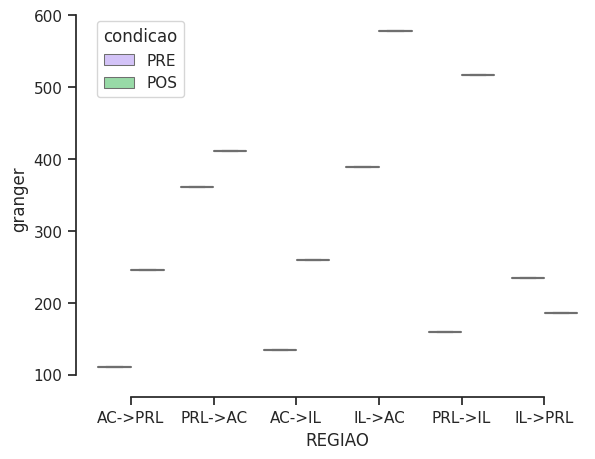

In [ ]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="REGIAO", y="granger",
            hue="condicao", palette=["m", "g"],
            data=df_barplot_granger)

sns.despine(offset=10, trim=True)

In [ ]:

f, axs = plt.subplots( 2,2, figsize=(11.5,5), gridspec_kw={'hspace': 0.5})
labels = ['AC->PRL' , 'PRL->AC',  'AC->IL',  'IL->AC' ,  'IL->PRL' , 'PRL->IL' ]
data_pre = [np.log(AC_PRL), np.log(PRL_AC), np.log(AC_IL), np.log(IL_AC), np.log(PRL_IL), np.log(IL_PRL) ]
data_pos = [np.log(AC_PRL_pos),np.log(PRL_AC_pos),np.log(AC_IL_pos),np.log(IL_AC_pos),np.log(PRL_IL_pos),np.log(IL_PRL_pos)]
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')


color = ['darkblue', 'darkblue', 'slateblue', 'slateblue', 'darkgreen' ,'darkgreen' ]

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]




for i in range(len(data_pre)):
    axs[0, 0].bar(labels[i], data_pre[i], width=0.6,  hatch=hatch_patterns[i], color=color[i], align='center')

    axs[1, 0].bar(i+1, data_pos[i], width=0.6,  hatch=hatch_patterns[i], color=color[i], align='center')

    axs[0, 0].set_title(labels[i], fontweight='bold', pad=12, fontsize=12)

plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')



In [ ]:
f, axs = plt.subplots( 2,1, figsize=(3,7), gridspec_kw={'hspace': 0.5})
labels = ['AC->PRL' , 'PRL->AC']  # 'AC->IL',  'IL->AC' ,  'IL->PRL' , 'PRL->IL' ]
data_pre = [np.log(AC_PRL), np.log(PRL_AC)] #np.log(AC_IL), np.log(IL_AC), np.log(PRL_IL), np.log(IL_PRL)]
data_pos = [np.log(AC_PRL_pos),np.log(PRL_AC_pos)] #np.log(AC_IL_pos),np.log(IL_AC_pos),np.log(PRL_IL_pos),np.log(IL_PRL_pos)]
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')
plt.ylim(0,10)

color = ['darkblue', 'slateblue']

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]

for ax in axs:
    ax.set_ylim(0, 10)


for i in range(len(data_pre)):
    axs[0].bar(labels[i], data_pre[i], width=0.6,  hatch=hatch_patterns[i], color = color[i] , align='center')

    axs[1].bar(labels[i], data_pos[i], width=0.6,  hatch=hatch_patterns[i], color = color[i], align='center')

    axs[0].set_title(labels[i], fontweight='bold', pad=12, fontsize=12)

plt.text(-0.2, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.2, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1].transAxes, ha='center', va='center', rotation='vertical')



In [ ]:

f, axs = plt.subplots( 2,2, figsize=(11.5,5), gridspec_kw={'hspace': 0.5})
labels = ['AC->PRL' , 'PRL->AC',  'AC->IL',  'IL->AC' ,  'IL->PRL' , 'PRL->IL' ]
data_pre = [np.log(AC_PRL), np.log(PRL_AC), np.log(AC_IL), np.log(IL_AC), np.log(PRL_IL), np.log(IL_PRL) ]
data_pos = [np.log(AC_PRL_pos),np.log(PRL_AC_pos),np.log(AC_IL_pos),np.log(IL_AC_pos),np.log(PRL_IL_pos),np.log(IL_PRL_pos)]
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')


color = ['darkblue', 'darkblue', 'slateblue', 'slateblue', 'darkgreen' ,'darkgreen' ,'olivedrab' ,'olivedrab' ,'darkred', 'darkred','indianred', 'indianred']

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]

for i in range(6):

    plt.bar(labels[i+1], data_pre[i], width=0.6,  hatch=hatch_patterns[i], align='center', ax=axs[0,0])
    plt.bar(i+1, data_pos[i], width=0.6,  hatch=hatch_patterns[i], align='center', ax=axs[1,0])

    axs[0,0].set_title( labels[i] , fontweight='bold',  pad = 12, fontsize = 12)
    # axs[1,i].set_title( None)
    # axs[0,i].set_ylabel(None)
    # axs[0,i].set_xlabel(None)
    # axs[1,i].set_xlabel(None)
    # axs[1,i].set_ylabel(None)

plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')


f.subplots_adjust(bottom=0.25)

cax = f.add_axes([0.92, 0.25, 0.015, 0.63])  # Posição e tamanho da colorbar
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', ticks=[0, 0.5, 1])
cb.outline.set_visible(False)
cb.set_label('Coherence', fontweight='bold')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = ([np.log(np.array(gc_cg_prl_pre[1])), np.log(np.array(gc_cg_prl_pos[1])), np.log(np.array(gc_cg_il_pre[1])), np.log(np.array(gc_cg_il_pos[1])), np.log(np.array(gc_il_prl_pre[1])),
  np.log(np.array(gc_il_prl_pos[1])), np.log(np.array(gc_il_cg_pre[1])), np.log(np.array(gc_il_cg_pos[1])), np.log(np.array(gc_prl_cg_pre[1])), np.log(np.array(gc_prl_cg_pos[1])),
  np.log(np.array(gc_prl_il_pre[1])), np.log(np.array(gc_prl_il_pos[1]))])

labels = ['AC->PRL pre', 'AC->PRL pos' , 'AC->IL pre', 'AC->IL pos', 'IL->PRL pre', 'IL->PRL pos',  'IL->AC pre' ,  'IL->AC pos' ,  'PRL->AC pre', 'PRL->AC pos', 'PRL->IL pre' ,'PRL->IL pos' ]

plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')

color = ['darkblue', 'darkblue', 'slateblue', 'slateblue', 'darkgreen' ,'darkgreen' ,'olivedrab' ,'olivedrab' ,'darkred', 'darkred','indianred', 'indianred']

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]

# Iterar sobre o número de dados e criar as barras
for i in range(len(data)):
    plt.bar(i+1, data[i], width=0.6, color=color[i], hatch=hatch_patterns[i], align='center', alpha=alpha[i])
    # plt.text(i+1, data[i]+0.1, '***', color='k', fontsize=8, horizontalalignment='center')
plt.title('OF pre and pos Stress', pad=15, fontweight = 'bold')
plt.ylabel('Granger Causality', fontsize=12)

plt.xticks(range(1,13), labels, fontsize=10, rotation=90)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/gc_pre_pos.jpeg')

plt.show()


# > PAC na mesma região

In [ ]:
# pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):


In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']
  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']
  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']
  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']
  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']
  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']
  data_il_pos.append(il_pos)

In [ ]:
# pac parameters PRL

lentaVector = np.arange(1,10,1)
altaVector = np.arange(10,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_prl_pre = []

for i in range(6):
  pac_pre = pac(data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_pre,axis = 0)

pac_prl_pos = []

for i in range(6):
  pac_pos = pac(data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_prl_pos,axis = 0)

<ipython-input-126-eaff37b83988>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


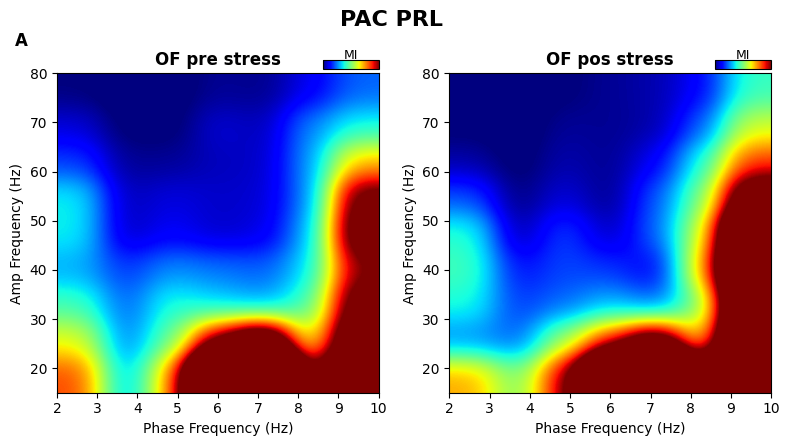

In [ ]:


vmin = 0.000025
vmax = 0.00050

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
# pac parameters PRL

lentaVector = np.arange(1,10,1)
altaVector = np.arange(10,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_cg_pre = []

for i in range(6):
  pac_pre = pac(data_cg_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_pre,axis = 0)

pac_cg_pos = []

for i in range(6):
  pac_pos = pac(data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_pos,axis = 0)

<ipython-input-123-59b6cc68a832>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


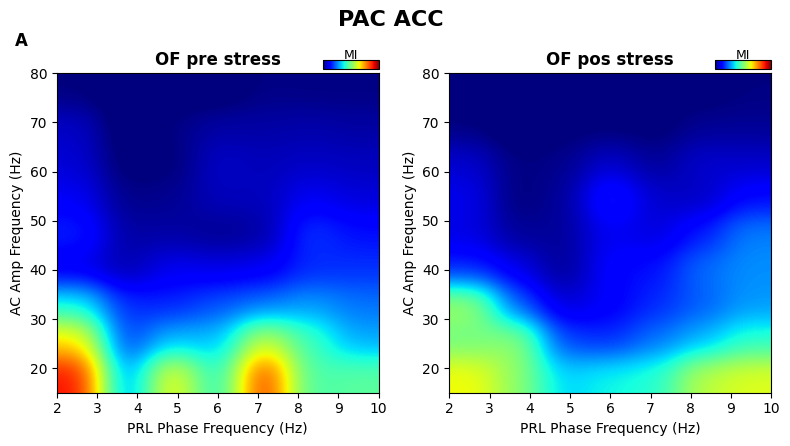

In [ ]:

vmin = 0.000025
vmax = 0.00050

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC ACC ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
# pac parameters PRL

lentaVector = np.arange(1,10,1)
altaVector = np.arange(10,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_il_pre = []

for i in range(6):
  pac_pre = pac(data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_pre,axis = 0)

pac_il_pos = []

for i in range(6):
  pac_pos = pac(data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_pos,axis = 0)

<ipython-input-133-983123c8cb72>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


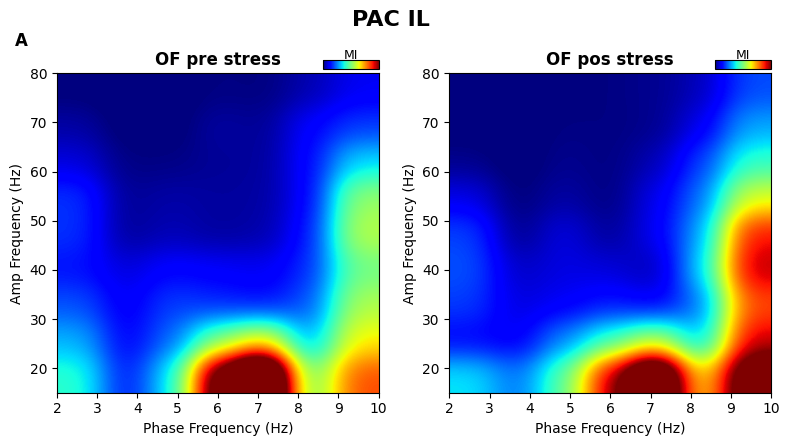

In [ ]:

vmin = 0.00003
vmax = 0.0010

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

# PAC

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']
  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']
  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']
  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']
  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']
  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']
  data_il_pos.append(il_pos)

# PRL_pre = np.mean(data_prl_pre, axis=0)
# PRL_pos = np.mean(data_prl_pos, axis=0)
# CG_pre = np.mean(data_cg_pre, axis=0)
# CG_pos = np.mean(data_cg_pos, axis=0)

In [ ]:
# pac parameters PRL CG

lentaVector = np.arange(1,10,1)
altaVector = np.arange(10,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_prl_cg_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_prl_pre[i]-np.mean(data_prl_pre[i]),data_cg_pre[i]-np.mean(data_cg_pre[i]),lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_cg_pre,axis = 0)

pac_prl_cg_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_prl_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_prl_cg_pos,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-80-515294032ea1>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


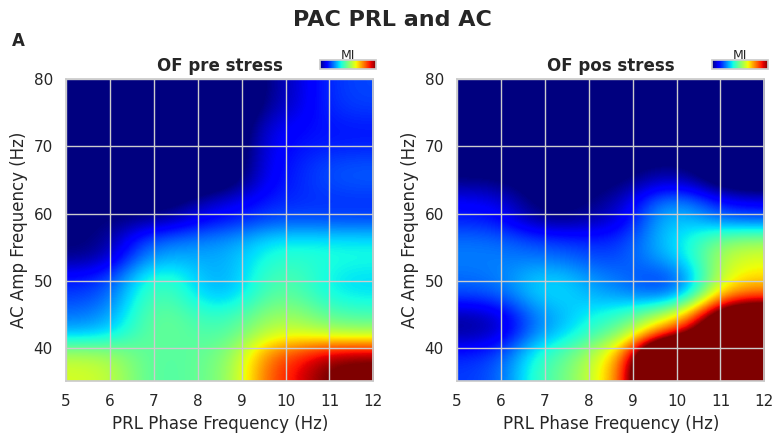

In [ ]:
# pac parameters prl ac

vmin = 0.000025
vmax = 0.00010

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL and AC', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
# pac parameters  CG prl

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_cg_prl_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_cg_pre[i],data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_prl_pre,axis = 0)

pac_cg_prl_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_cg_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_prl_pos,axis = 0)

<ipython-input-83-8d3f170c2162>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


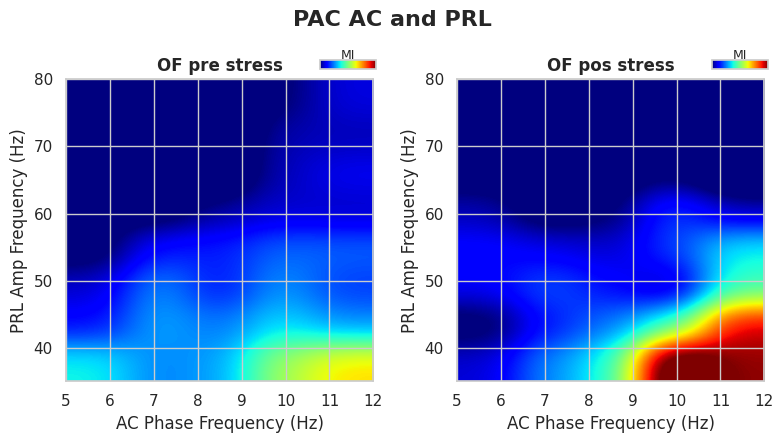

In [ ]:
# # pac parameters AC prl

vmin = 0.00003
vmax = 0.00014

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil



figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC AC and PRL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_AC_PRL_4animais.jpeg')
# plt.show()

In [ ]:
# # pac parameters   il PRL

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_il_prl_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes( data_il_pre[i], data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_prl_pre,axis = 0)

pac_il_prl_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_il_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_prl_pos,axis = 0)

<ipython-input-95-6ff08598e61b>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


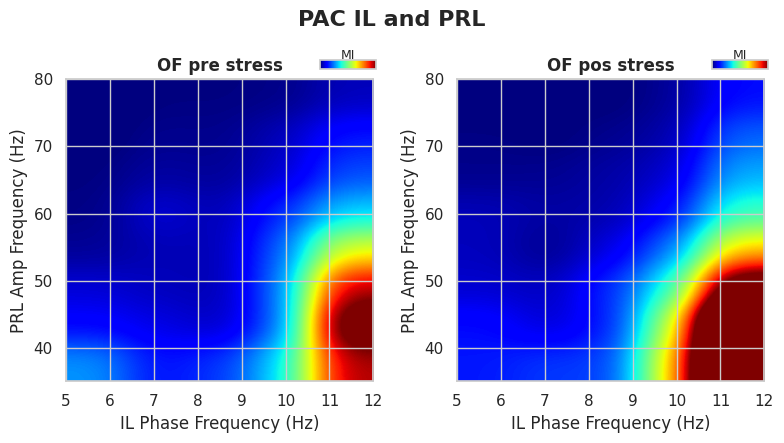

In [ ]:
# #pac parameters

# vmin = 0.000001
# vmax = 0.000009

vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
vmax = np.percentile(data_pac_pre, 98)  # Define vmax como o 95º percentil


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL and PRL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_IL_PRL_4animais.jpeg')


In [ ]:
vmax

0.0005643805762670307

In [ ]:
# # pac parameters  PRL il

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_prl_il_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_prl_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_il_pre,axis = 0)

pac_prl_il_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_prl_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_prl_il_pos,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-98-04fb6e5728b3>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


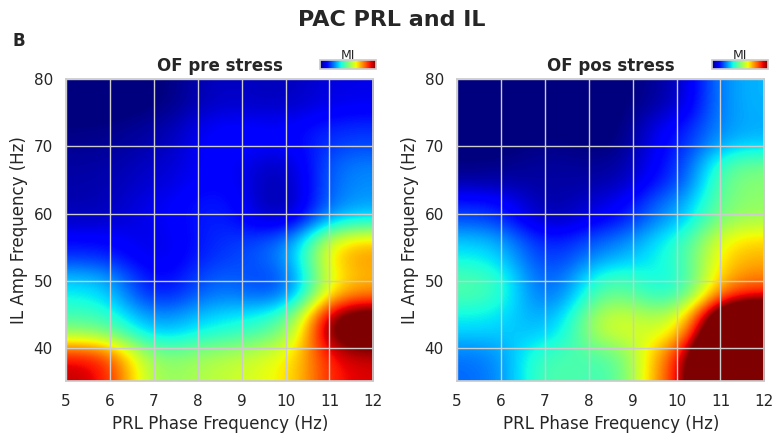

In [ ]:
# #pac parameters



vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
vmax = np.percentile(data_pac_pre, 98)  # Define vmax como o 95º percentil


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL and IL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "B", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_IL_4animais.jpeg')

In [ ]:
# # pac parameters  CG il

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_cg_il_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_cg_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_il_pre,axis = 0)

pac_cg_il_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_cg_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_il_pos,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-100-849ae94d3b58>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


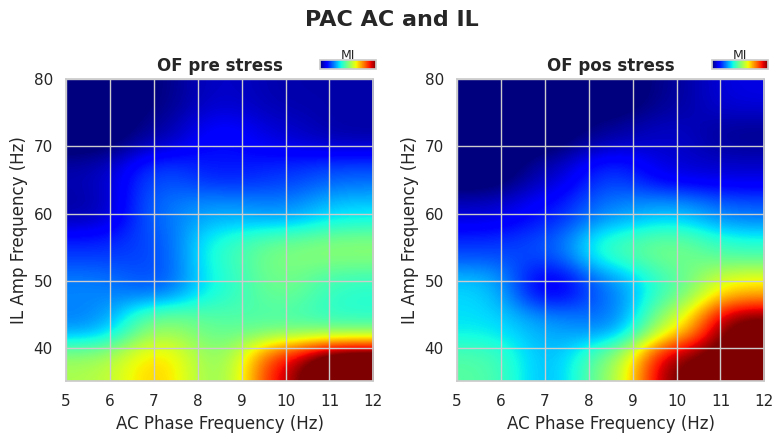

In [ ]:
# # pac parameters

# vmin = 0.00003
# vmax = 0.00014

vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
vmax = np.percentile(data_pac_pre, 98)  # Define vmax como o 95º percentil


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC AC and IL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_AC_IL_4animais.jpeg')

In [ ]:
# # pac parameters   il cg

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_il_cg_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_il_pre[i],data_cg_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_cg_pre,axis = 0)

pac_il_cg_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_il_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_cg_pos,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-102-49d025144b61>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


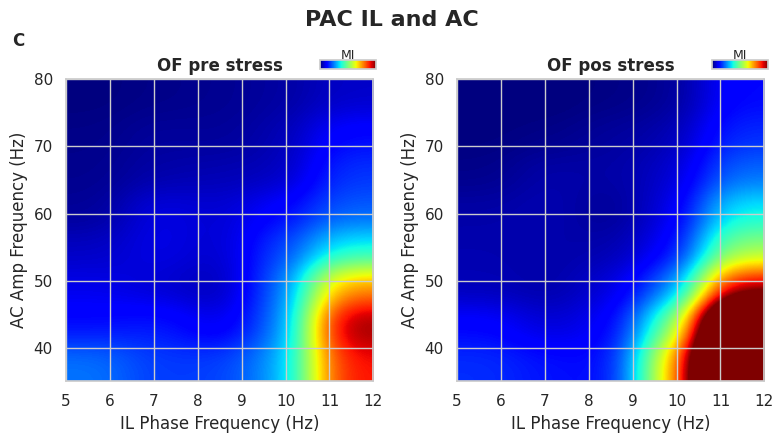

In [ ]:
# # pac parameters

# vmin = 0.00003
# vmax = 0.00014

vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
vmax = np.percentile(data_pac_pre, 98)  # Define vmax como o 95º percentil


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL and AC', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "C", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_IL_AC_4animais.jpeg')

> # ESPECTROGRAMAS

# US e CS cut

In [ ]:
ch_aleatorio = lista_sinais[4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# us cut

media_movel = pd.DataFrame(abs(ch_aleatorio)).rolling(window=1000).mean()
threshold = 1490
US = np.array(threshold < media_movel)

In [ ]:
indices_US = []

for x in range(len(US)):
  if US[x] == True and US[x-1]== False and US[x-100]== False and US[x-1000]== False and US[x-2000]== False:
          indices_US.append(x)

indices_CS = []
for i in indices_US:
  x=int(i-2000)
  indices_CS.append(x)

(0.0, 100000.0)

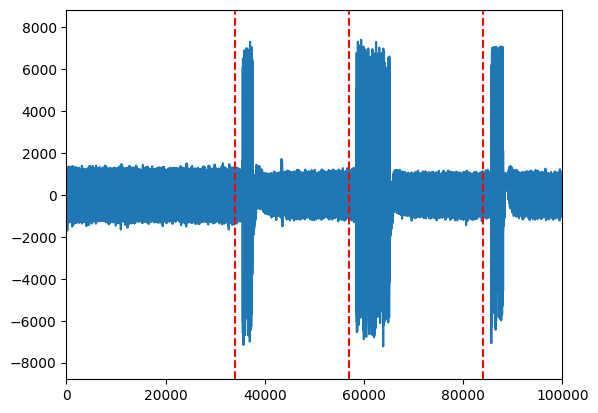

In [ ]:
plt.plot(ch_aleatorio)
for i in indices_CS:
  plt.axvline(x=i, color='r', linestyle='--', label='Linha Vertical em x=3')

plt.xlim(0,100000)

In [ ]:
# cs cut

contador = 0
inicio = 0
final = 0

CS_cut = []
for sn in indices_CS:
    contador+=1
    inicio = sn-2000
    final = sn+2000
    cut = np.array(ch_aleatorio[inicio:final])

    df_cs_temp = pd.DataFrame({'CS': cut, 'trial': contador})
    CS_cut.append(df_cs_temp)

df_cs = pd.concat(CS_cut)




In [ ]:
spectrogram = df_cs[( df_cs['trial'] == 2 )]['CS']
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)


spec = np.abs(signal.cwt(spectrogram, signal.morlet2, widths, w=w))



Text(0.5, 1.0, 'PRL: Spectrogram OF pre screening')

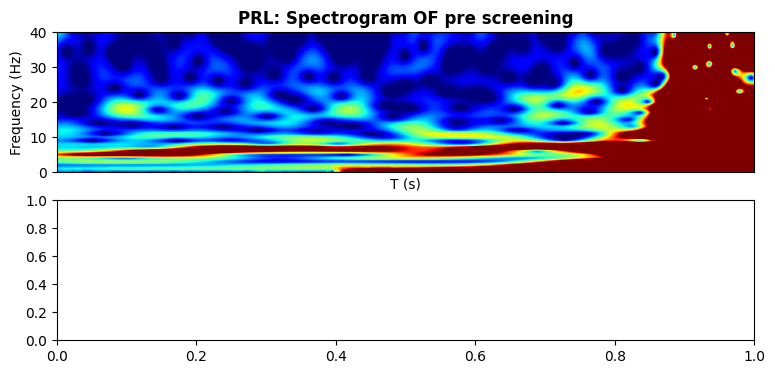

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 40])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('PRL: Spectrogram OF pre screening', fontweight='bold')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'PRL: Spectrogram OF pre screening')

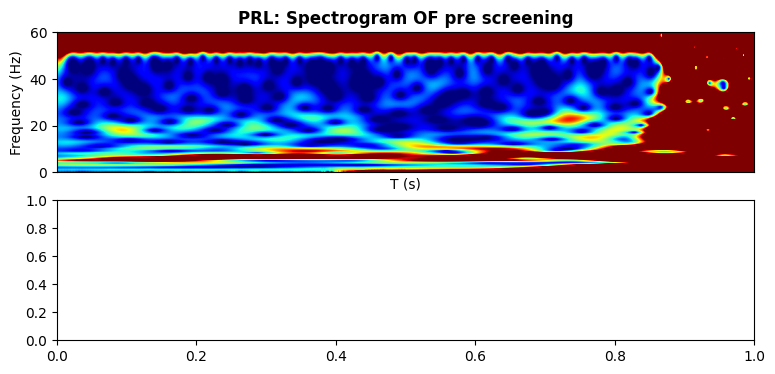

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 60])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('PRL: Spectrogram OF pre screening', fontweight='bold')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


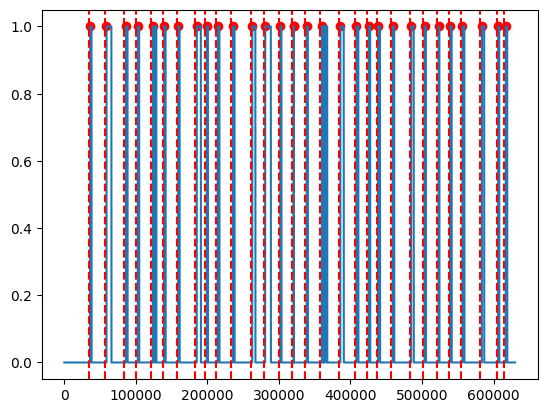

In [ ]:
plt.plot(US)
plt.scatter(indices_US, US[indices_US], color='red', marker='o', label='Ponto US')




Spectrograms were computed using the complex wavelet transform scipy function, with signal.morlet2 parameter. The formula used to calculate the bandwidths was “widths = w * srate / (2 * freq *𝛑)”, where w is the constant central frequency (w = 12Hz). After computing each individual spectrogram, we averaged them to yield the mean spectrogram.

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']

  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']

  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']

  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']

  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']

  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']

  data_il_pos.append(il_pos)



# PRL_pre = np.mean(data_prl_pre, axis=0)
# PRL_pos = np.mean(data_prl_pos, axis=0)
# CG_pre = np.mean(data_cg_pre, axis=0)
# CG_pos = np.mean(data_cg_pos, axis=0)
# IL_pre = np.mean(data_il_pre, axis=0)
# IL_pos = np.mean(data_il_pos, axis=0)


In [ ]:
len(data_prl_pre[0])/1000

In [ ]:
spectrogram_prl_pre = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_prl_pre)):
  spec = np.abs(signal.cwt(data_prl_pre[i], signal.morlet2, widths, w=w))
  spectrogram_prl_pre.append(spec)

spec_prl_pre = np.mean(spectrogram_prl_pre, axis = 0)

spectrogram_prl_pos = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_prl_pos)):
  spec_pos = np.abs(signal.cwt(data_prl_pos[i], signal.morlet2, widths, w=w))
  spectrogram_prl_pos.append(spec_pos)

spec_prl_pos = np.mean(spectrogram_prl_pos, axis = 0)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec_prl_pre, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 60])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('PRL: Spectrogram OF pre screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[0], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])

axs[0].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[0].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

# subplot 2

im = axs[1].imshow(spec_prl_pos, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[1].set_ylim([0, 60])
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('T (s)')
axs[1].set_xticks([])
axs[1].set_title('PRL: Spectrogram OF pos screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[1], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])


axs[1].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[1].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
plt.show()


In [ ]:
spectrogram_cg_pre = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_cg_pre)):
  spec = np.abs(signal.cwt(data_cg_pre[i], signal.morlet2, widths, w=w))
  spectrogram_cg_pre.append(spec)

spec_cg_pre = np.mean(spectrogram_cg_pre, axis = 0)

spectrogram_cg_pos = []
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

for i in range(len(data_cg_pos)):
  spec_pos = np.abs(signal.cwt(data_cg_pos[i], signal.morlet2, widths, w=w))
  spectrogram_cg_pos.append(spec_pos)

spec_cg_pos = np.mean(spectrogram_cg_pos, axis = 0)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec_cg_pre, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 60])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('CG: Spectrogram OF pre screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[0], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])

axs[0].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[0].text(80000, 54, '10s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

# subplot 2

im = axs[1].imshow(spec_cg_pos, interpolation='gaussian', cmap='jet', vmin=100, vmax=1000, aspect='auto', alpha=1, label='Spectrogram')
axs[1].set_ylim([0, 60])
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('T (s)')
axs[1].set_xticks([])
axs[1].set_title('CG: Spectrogram OF pos screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[1], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([100,500, 1000])


axs[1].hlines(y=56, xmin=75000, xmax=85000, color='white', linewidth = 2)
axs[1].text(80000, 54, '1s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
plt.show()